# Where Do Distributions Come From?

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [99]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [7]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

from utils import decorate

## The Normal Distribution

The normal distribution, also known as the Gaussian distribution, is a good model for many of the distributions we see in natural and engineered systems.

For example, the distribution of birthweights is approximately Gaussian. Here's data from the National Survey of Family Growth we can use to test this claim.

In [13]:
download('https://github.com/AllenDowney/ElementsOfDataScience/raw/master/data/nsfg.hdf')

Downloaded nsfg.hdf


In [15]:
import pandas as pd

nsfg = pd.read_hdf('nsfg.hdf', 'nsfg')
nsfg.head()

,CASEID,OUTCOME,BIRTHWGT_LB1,BIRTHWGT_OZ1,PRGLNGTH,NBRNALIV,AGECON,AGEPREG,BIRTHORD,HPAGELB,WGT2015_2017
0,70627,1,7.0,8.0,40,1.0,28,29.0,1.0,5.0,19877.457610
1,70627,4,NaN,NaN,14,NaN,32,32.0,NaN,NaN,19877.457610
2,70627,1,9.0,2.0,39,1.0,33,33.0,2.0,5.0,19877.457610
3,70628,1,6.0,9.0,39,1.0,17,18.0,1.0,1.0,4221.017695
4,70628,1,7.0,0.0,39,1.0,19,20.0,2.0,2.0,4221.017695


Birthweight is encoded in two variables, which we have to clean and then combine.

In [48]:
nsfg['BIRTHWGT_LB1'].replace([98, 99], np.nan, inplace=True)

In [49]:
nsfg['BIRTHWGT_OZ1'].replace([98, 99], np.nan, inplace=True)

In [50]:
birthweight = nsfg['BIRTHWGT_LB1'] + nsfg['BIRTHWGT_OZ1'] / 16
birthweight.describe()

count    6540.000000
mean        7.180218
std         1.377160
min         0.500000
25%         6.437500
50%         7.250000
75%         8.000000
max        14.187500
dtype: float64

One way to visualize the distribution of birthweights is a KDE plot, which uses kernel density estimation.

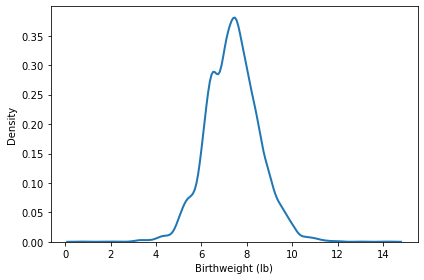

In [55]:
import seaborn as sns

sns.kdeplot(birthweight)

decorate(xlabel='Birthweight (lb)',
         ylabel='Density')

The vertical axis is density, which is a relative likelihood for each weight.

We can see that this distribution is approximately bell-shaped, which is the characteristic shape of the Gaussian distribution.

But it is not easy to tell, by looking at a KDE plot, whether the Gaussian distribution is a good model for the data.
A better option is to plot the CDF of the data and compare it to the CDF of a Gaussian distribution with the same mean and standard deviation.

In [100]:
from empiricaldist import Cdf
from scipy.stats import norm

def plot_normal_cdf(sample, **options):
    mean, std = sample.mean(), sample.std()
    low, high = sample.min(), sample.max()

    xs = np.linspace(low, high)
    ys = norm.cdf(xs, mean, std)

    plt.plot(xs, ys, color='gray', alpha=0.5, label='Normal model')

    cdf = Cdf.from_seq(sample)
    cdf.plot(**options)

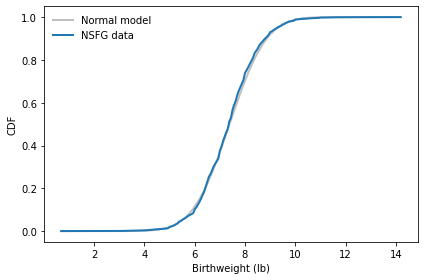

In [101]:
plot_normal_cdf(birthweight, label='NSFG data')

decorate(xlabel='Birthweight (lb)',
         ylabel='CDF')

The CDF of a Gaussian distribution has a recognizable sigmoid shape. And by comparing it with the data, we can see where the model fits well and where it deviates.

If you think the Gaussian model is a good choice for a particular dataset, one way to check is a [normal probability plot](https://en.wikipedia.org/wiki/Normal_probability_plot), which plots the observed data against randomly-generated data from a Gaussian distribution.

In [62]:
def normal_probability_plot(sample, fit_color='0.8', **options):
    """Makes a normal probability plot with a fitted line.

    sample: sequence of numbers
    fit_color: color string for the fitted line
    options: passed along to Plot
    """   
    n = len(sample)
    mean, std = np.mean(sample), np.std(sample)

    xs = np.random.normal(mean, std, n)
    xs.sort()
    
    plt.plot(xs, xs, color=fit_color, label='model')

    ys = np.array(sample, copy=True)
    ys.sort()
    
    plt.plot(xs, ys, **options)

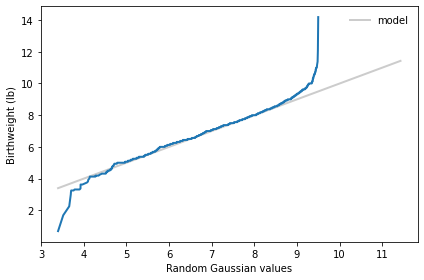

In [65]:
normal_probability_plot(birthweight)
decorate(xlabel='Random Gaussian values',
         ylabel='Birthweight (lb)')

The advantage of a normal probability plot is that it shows deviations from the normal model more clearly, especially in the tails.

The drawback is that it might show deviations *too* clearly -- a model that's good enough for practical purposes might look pretty bad on a normal probability plot.

**Exercise:** One reason the distribution of birthweight deviated from the Gaussian model is that it includes some very light babies that were born pre-term, which is commonly defined to mean prior to the 36th week of pregnancy.

The following code selects the birthweights of babies who were born full term. Run this code, and then go back to run the visualizations in this section. Is the distribution of birthweights for full-term babies closer to a Gaussian model?

In [66]:
full_term = nsfg['PRGLNGTH'] >= 36
birthweight = birthweight[full_term]

## Central Limit Theorem

One reason the Gaussian distribution is a good model for so many think we see in the real world is the Central Limit Theorem, which says:

> If you add up independent values from a distribution with finite mean and variance, the sum converges on a normal distribution.

To demonstrate, the following function generates samples with difference sizes from an exponential distribution.

In [67]:
def make_expo_samples(beta=2.0, iters=1000):
    """Generates samples from an exponential distribution.

    beta: parameter
    iters: number of samples to generate for each size

    returns: map from sample size to sample
    """
    samples = {}
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.exponential(beta, n))
                  for _ in range(iters)]
        samples[n] = sample
    return samples

This function generates normal probability plots for samples with various sizes.

In [70]:
def normal_plot_samples(samples, ylabel=''):
    """Makes normal probability plots for samples.

    samples: map from sample size to sample
    label: string
    """
    plt.figure(figsize=(8, 3))
    
    plot = 1
    for n, sample in samples.items():
        plt.subplot(1, 3, plot)
        plot += 1
        
        normal_probability_plot(sample)

        decorate(title='n=%d' % n,
                 xticks=[],
                 yticks=[],
                 xlabel='Random Gaussian values',
                 ylabel=ylabel)

The following plot shows how the sum of exponential variates converges to normal as sample size increases.

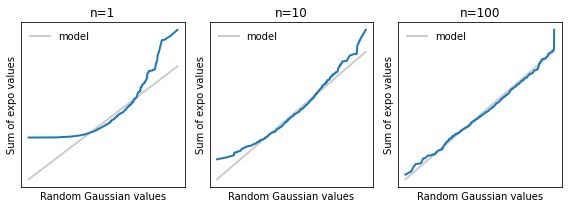

In [71]:
samples = make_expo_samples()
normal_plot_samples(samples, ylabel='Sum of expo values')

The exponential distribution is not very heavy tailed, so the number of addends doesn't have to be very big before the sum is well modeled by a Gaussian distribution.

The lognormal distribution has higher variance, so it requires a larger sample size before it converges to normal.

In [80]:
def make_lognormal_samples(mu=1.0, sigma=1.0, iters=1000):
    """Generates samples from a lognormal distribution.

    mu: parmeter
    sigma: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = {}
    for n in [1, 10, 100]:
        sample = [np.sum(np.random.lognormal(mu, sigma, n))
                  for _ in range(iters)]
        samples[n] = sample
    return samples

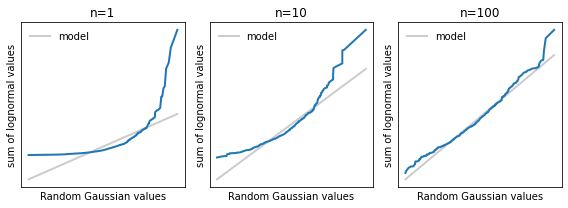

In [81]:
samples = make_lognormal_samples()
normal_plot_samples(samples, ylabel='sum of lognormal values')

The Pareto distribution has infinite variance, and sometimes infinite mean, depending on the parameters.  It violates the requirements of the CLT and does not generally converge to normal.

In [82]:
def make_pareto_samples(alpha=1.0, iters=1000):
    """Generates samples from a Pareto distribution.

    alpha: parameter
    iters: number of samples to generate for each size

    returns: list of samples
    """
    samples = {}

    for n in [1, 10, 100]:
        sample = [np.sum(np.random.pareto(alpha, n))
                  for _ in range(iters)]
        samples[n] = sample
    return samples

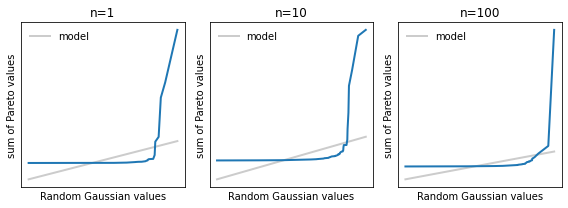

In [83]:
samples = make_pareto_samples()
normal_plot_samples(samples, ylabel='sum of Pareto values')

If the random variates are correlated, that also violates the CLT, so the sums don't generally converge.

To generate correlated values, we generate correlated normal values and then transform to whatever distribution we want.

In [84]:
def generate_correlated(rho, n):
    """Generates a sequence of correlated values from a standard normal dist.
    
    rho: coefficient of correlation
    n: length of sequence

    returns: iterator
    """
    x = np.random.normal(0, 1)
    yield x

    sigma = np.sqrt(1 - rho**2)
    for _ in range(n-1):
        x = np.random.normal(x * rho, sigma)
        yield x

In [318]:
from scipy.stats import norm
from scipy.stats import expon

def generate_expo_correlated(rho, n):
    """Generates a sequence of correlated values from 
    an exponential dist.

    rho: coefficient of correlation
    n: length of sequence

    returns: NumPy array
    """
    normal = list(generate_correlated(rho, n))
    uniform = norm.cdf(normal)
    expo = expon.ppf(uniform)
    return expo

In [86]:
def make_correlated_samples(rho=0.9, iters=1000):
    """Generates samples from a correlated exponential distribution.

    rho: correlation
    iters: number of samples to generate for each size

    returns: list of samples
    """    
    samples = {}
    for n in [1, 10, 100]:
        sample = [np.sum(generate_expo_correlated(rho, n))
                  for _ in range(iters)]
        samples[n] = sample
    return samples


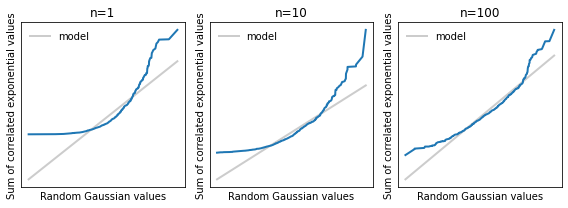

In [87]:
samples = make_correlated_samples()
normal_plot_samples(samples, 
                    ylabel='Sum of correlated exponential values')

## Lognormal Distributions

The following cells download and read data from the [Behavior Risk Factor Surveilance System](https://www.cdc.gov/brfss/index.html) (BRFSS).

In [108]:
download('https://github.com/AllenDowney/ElementsOfDataScience/raw/master/data/brfss.hdf')

In [90]:
import pandas as pd

brfss = pd.read_hdf('brfss.hdf', 'brfss')
brfss.head()

,SEQNO,HTM4,WTKG3,_SEX,_AGEG5YR,_VEGESU1,_INCOMG,_LLCPWT,AGE
0,2019000001,157.0,69.85,2,13.0,114.0,2,135.304080,82.0
1,2019000002,163.0,48.99,2,11.0,121.0,3,1454.882220,72.0
2,2019000003,165.0,86.18,2,10.0,164.0,5,215.576852,67.0
3,2019000004,165.0,55.34,2,13.0,NaN,4,261.282838,82.0
4,2019000005,152.0,49.90,2,13.0,178.0,9,535.270103,82.0


One of the columns contains self-reports weights in kilograms for a representative sample of adult residents in the United States.

In [91]:
weight = brfss['WTKG3']
weight.describe()

count    388520.000000
mean         82.170295
std          21.025989
min          22.680000
25%          68.040000
50%          79.380000
75%          92.990000
max         281.230000
Name: WTKG3, dtype: float64

The distributions are different for men and women, so I'll partition them.

In [94]:
male = brfss['_SEX'] == 1
female = brfss['_SEX'] == 2

weight_male = brfss.loc[male, 'WTKG3']
weight_female = brfss.loc[female, 'WTKG3']

In [104]:
# Solution

weight_male = np.log(weight_male)
weight_female = np.log(weight_female)

To see whether adult weights are well modeled by a Gaussian distribution, we'll compare CDFs.

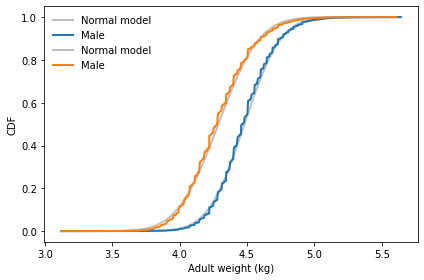

In [105]:
plot_normal_cdf(weight_male, label='Male')
plot_normal_cdf(weight_female, label='Male')

decorate(xlabel='Adult weight (kg)',
         ylabel='CDF')

And make a normal probability plot.

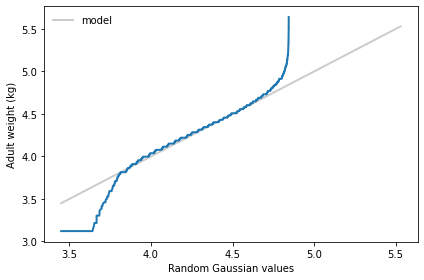

In [107]:
normal_probability_plot(weight_male)

decorate(xlabel='Random Gaussian values',
         ylabel='Adult weight (kg)')

**Exercise:** If we think a distribution might be lognormal, one way to check is to compute the log of the values and test whether they fit a normal distribution.

Compute the log of adult weight for men and women and run the tests in this section with the transformed values.

## Where Do Lognormal Distributions Come From?

It seems that the distribution of adult weights is approximately lognormal. One possible explanation is that the weight a person gains each year is proportional to their current weight. In that case, adult weight is the product of a large number of multiplicative factors:

```
w = w0 f1 f2 ... fn  
```

where `w` is adult weight, `w0` is birth weight, and `fi` is the weight gain factor for year `i`.

The log of a product is the sum of the logs of the factors:

```
logw = log w0 + log f1 + log f2 + ... + log fn 
```

So by the Central Limit Theorem, the distribution of `logw` is approximately normal for large `n`, which implies that the distribution of `w` is lognormal.

To model this phenomenon, choose a distribution for `f` that seems reasonable, then generate a sample of adult weights by choosing a random value from the distribution of birth weights, choosing a sequence of factors from the distribution of `f`, and computing the product. What value of `n` is needed to converge to a lognormal distribution?

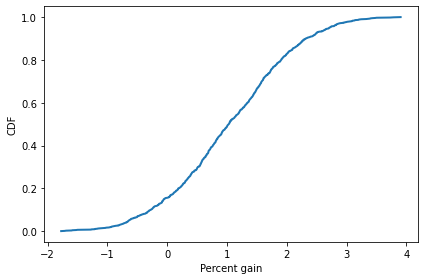

In [111]:
mu = 1.01
sigma = 0.01

sample = np.random.normal(mu, sigma, 1000)
percent_gain = (sample-1) * 100
Cdf.from_seq(percent_gain).plot()

decorate(xlabel='Percent gain',
         ylabel='CDF')

In [146]:
def simulate_life():
    w0 = 3
    rel_gains = np.random.normal(mu, sigma, 320)
    weight = w0 * rel_gains.prod()
    return weight

In [147]:
sim_weights = np.array([simulate_life() for _ in range(1000)])
sim_weights.mean()

72.50540907896162

In [152]:
# Solution

sim_weights = np.log(sim_weights)

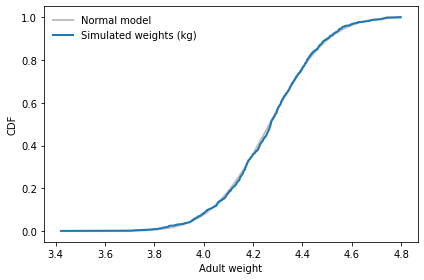

In [153]:
plot_normal_cdf(sim_weights, label='Simulated weights (kg)')

decorate(xlabel='Adult weight',
         ylabel='CDF')

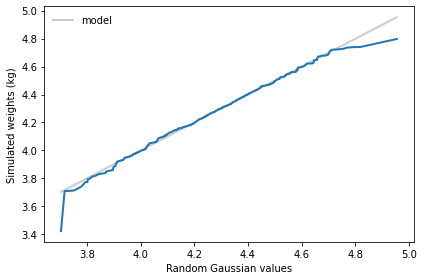

In [154]:
normal_probability_plot(sim_weights)

decorate(xlabel='Random Gaussian values',
         ylabel='Simulated weights (kg)')

## Distribution of File Sizes

The following command walks the entire file system (or at least the parts we have permission to read) and collects the sizes of the files.

In [186]:
!find / -type f -printf "%s\n" > file_sizes

find: ‘/proc/tty/driver’: Permission denied
find: ‘/proc/1/task/1/fd’: Permission denied
find: ‘/proc/1/task/1/fdinfo’: Permission denied
find: ‘/proc/1/task/1/ns’: Permission denied
find: ‘/proc/1/fd’: Permission denied
find: ‘/proc/1/map_files’: Permission denied
find: ‘/proc/1/fdinfo’: Permission denied
find: ‘/proc/1/ns’: Permission denied
find: ‘/proc/2/task/2/fd’: Permission denied
find: ‘/proc/2/task/2/fdinfo’: Permission denied
find: ‘/proc/2/task/2/ns’: Permission denied
find: ‘/proc/2/fd’: Permission denied
find: ‘/proc/2/map_files’: Permission denied
find: ‘/proc/2/fdinfo’: Permission denied
find: ‘/proc/2/ns’: Permission denied
find: ‘/proc/3/task/3/fd’: Permission denied
find: ‘/proc/3/task/3/fdinfo’: Permission denied
find: ‘/proc/3/task/3/ns’: Permission denied
find: ‘/proc/3/fd’: Permission denied
find: ‘/proc/3/map_files’: Permission denied
find: ‘/proc/3/fdinfo’: Permission denied
find: ‘/proc/3/ns’: Permission denied
find: ‘/proc/4/task/4/fd’: Permission denied
find:

find: ‘/proc/154/task/154/fdinfo’: Permission denied
find: ‘/proc/154/task/154/ns’: Permission denied
find: ‘/proc/154/fd’: Permission denied
find: ‘/proc/154/map_files’: Permission denied
find: ‘/proc/154/fdinfo’: Permission denied
find: ‘/proc/154/ns’: Permission denied
find: ‘/proc/155/task/155/fd’: Permission denied
find: ‘/proc/155/task/155/fdinfo’: Permission denied
find: ‘/proc/155/task/155/ns’: Permission denied
find: ‘/proc/155/fd’: Permission denied
find: ‘/proc/155/map_files’: Permission denied
find: ‘/proc/155/fdinfo’: Permission denied
find: ‘/proc/155/ns’: Permission denied
find: ‘/proc/156/task/156/fd’: Permission denied
find: ‘/proc/156/task/156/fdinfo’: Permission denied
find: ‘/proc/156/task/156/ns’: Permission denied
find: ‘/proc/156/fd’: Permission denied
find: ‘/proc/156/map_files’: Permission denied
find: ‘/proc/156/fdinfo’: Permission denied
find: ‘/proc/156/ns’: Permission denied
find: ‘/proc/165/task/165/fd’: Permission denied
find: ‘/proc/165/task/165/fdinfo’:

find: ‘/proc/953/task/953/fd’: Permission denied
find: ‘/proc/953/task/953/fdinfo’: Permission denied
find: ‘/proc/953/task/953/ns’: Permission denied
find: ‘/proc/953/task/954/fd’: Permission denied
find: ‘/proc/953/task/954/fdinfo’: Permission denied
find: ‘/proc/953/task/954/ns’: Permission denied
find: ‘/proc/953/task/956/fd’: Permission denied
find: ‘/proc/953/task/956/fdinfo’: Permission denied
find: ‘/proc/953/task/956/ns’: Permission denied
find: ‘/proc/953/fd’: Permission denied
find: ‘/proc/953/map_files’: Permission denied
find: ‘/proc/953/fdinfo’: Permission denied
find: ‘/proc/953/ns’: Permission denied
find: ‘/proc/961/task/961/fd’: Permission denied
find: ‘/proc/961/task/961/fdinfo’: Permission denied
find: ‘/proc/961/task/961/ns’: Permission denied
find: ‘/proc/961/task/1018/fd’: Permission denied
find: ‘/proc/961/task/1018/fdinfo’: Permission denied
find: ‘/proc/961/task/1018/ns’: Permission denied
find: ‘/proc/961/task/1019/fd’: Permission denied
find: ‘/proc/961/task

find: ‘/proc/1477/task/1477/fd’: Permission denied
find: ‘/proc/1477/task/1477/fdinfo’: Permission denied
find: ‘/proc/1477/task/1477/ns’: Permission denied
find: ‘/proc/1477/task/1481/fd’: Permission denied
find: ‘/proc/1477/task/1481/fdinfo’: Permission denied
find: ‘/proc/1477/task/1481/ns’: Permission denied
find: ‘/proc/1477/task/1483/fd’: Permission denied
find: ‘/proc/1477/task/1483/fdinfo’: Permission denied
find: ‘/proc/1477/task/1483/ns’: Permission denied
find: ‘/proc/1477/fd’: Permission denied
find: ‘/proc/1477/map_files’: Permission denied
find: ‘/proc/1477/fdinfo’: Permission denied
find: ‘/proc/1477/ns’: Permission denied
find: ‘/proc/2076/task/2076/fd’: Permission denied
find: ‘/proc/2076/task/2076/fdinfo’: Permission denied
find: ‘/proc/2076/task/2076/ns’: Permission denied
find: ‘/proc/2076/task/2076/net’: Invalid argument
find: ‘/proc/2076/fd’: Permission denied
find: ‘/proc/2076/map_files’: Permission denied
find: ‘/proc/2076/fdinfo’: Permission denied
find: ‘/proc

find: ‘/sys/kernel/debug’: Permission denied
find: ‘/sys/fs/pstore’: Permission denied
find: ‘/sys/fs/bpf’: Permission denied
find: ‘/root’: Permission denied
find: ‘/lost+found’: Permission denied
find: ‘/etc/cups/ssl’: Permission denied
find: ‘/etc/polkit-1/localauthority’: Permission denied
find: ‘/etc/ssl/private’: Permission denied
find: ‘/run/wpa_supplicant’: Permission denied
find: File system loop detected; ‘/run/timeshift/backup’ is part of the same file system loop as ‘/’.
find: ‘/run/lightdm’: Permission denied
find: ‘/run/udisks2’: Permission denied
find: ‘/run/cups/certs’: Permission denied
find: ‘/run/user/1000/inaccessible’: Permission denied
find: ‘/run/sudo’: Permission denied
find: ‘/run/speech-dispatcher’: Permission denied
find: ‘/run/openvpn-server’: Permission denied
find: ‘/run/openvpn-client’: Permission denied
find: ‘/run/cryptsetup’: Permission denied
find: ‘/run/lvm’: Permission denied
find: ‘/run/systemd/resolve/netif’: Permission denied
find: ‘/run/systemd/

find: ‘/timeshift/snapshots/2021-10-17_11-00-01/localhost/var/lib/AccountsService/users’: Permission denied
find: ‘/timeshift/snapshots/2021-10-17_11-00-01/localhost/var/lib/colord/.cache’: Permission denied
find: ‘/timeshift/snapshots/2021-10-17_11-00-01/localhost/var/lib/lightdm-data/lightdm’: Permission denied
find: ‘/timeshift/snapshots/2021-10-17_11-00-01/localhost/var/lib/udisks2’: Permission denied
find: ‘/timeshift/snapshots/2021-10-17_11-00-01/localhost/var/lib/bluetooth/BC:17:B8:71:A5:97’: Permission denied
find: ‘/timeshift/snapshots/2021-10-17_11-00-01/localhost/var/lib/private’: Permission denied
find: ‘/timeshift/snapshots/2021-10-17_11-00-01/localhost/var/lib/lightdm’: Permission denied
find: ‘/timeshift/snapshots/2021-10-17_11-00-01/localhost/var/lib/NetworkManager’: Permission denied


Here are the first few lines.

In [296]:
!head file_sizes

2147483648
2980472
98680
30896
35336
76112
30480
96192
776672
26


And here's how we can read them into a Pandas `Dataframe`.

In [311]:
df = pd.read_csv('file_sizes', header=None)
df.columns = ['File size']
df.shape

(5556267, 1)

In [313]:
file_sizes = df['File size']
file_sizes.describe()

count    5.556267e+06
mean     2.538621e+07
std      5.970603e+10
min      0.000000e+00
25%      5.870000e+02
50%      2.441000e+03
75%      8.447000e+03
max      1.407375e+14
Name: File size, dtype: float64

To see whether they might be lognormal, I'll compute their logarithms.

In [314]:
file_sizes[file_sizes == 0] = np.nan
#file_sizes[file_sizes > 1e13] = np.nan

In [315]:
log_file_sizes = np.log10(file_sizes)

And here's what the CDF of the transformed sizes looks like.

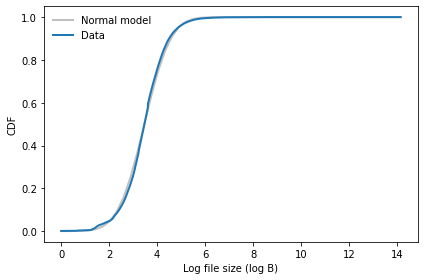

In [316]:
plot_normal_cdf(log_file_sizes, label='Data')

decorate(xlabel='Log file size (log B)',
         ylabel='CDF')

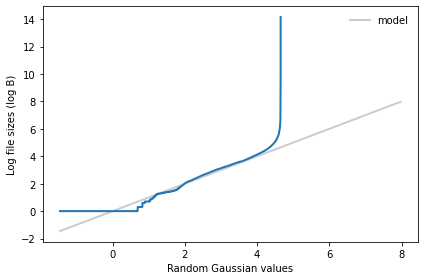

In [317]:
normal_probability_plot(log_file_sizes)

decorate(xlabel='Random Gaussian values',
         ylabel='Log file sizes (log B)')

Why do we think the distribution of file sizes might be lognormal?
[Here's my answer](https://github.com/AllenDowney/ThinkComplexity2/raw/master/papers/downey01structural.pdf).

Or maybe it follows a power law?

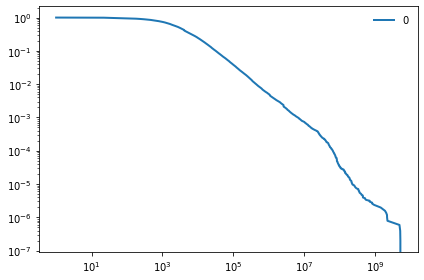

In [221]:
cdf = Cdf.from_seq(file_sizes)
(1-cdf).plot()
decorate(xscale='log',
         yscale='log')

## Distribution of Wealth

A model like this is one of many possible explanations for the heavy-tailed distribution of wealth.

Suppose everyone saves \\$2000 a year for 50 years. 
With no return on investment, they would have \\$100,000.

But suppose they make 5% annually, on average, with variability from year to year. Let's see what the distribution of wealth looks like when they "retire".

In [247]:
def simulate_wealth():
    savings = 2000
    total = 0
    for i in range(50):
        total *= np.random.normal(1.05, 0.05)
        total += savings
    return total

In [248]:
sim_wealth = np.array([simulate_wealth() for _ in range(1000)])
sim_wealth.mean()

416056.3866990387

On average, they have more than \\$400,000, which means that most of their wealth came from return on investment, not savings.

Now let's see what the distributions looks like.

In [252]:
log_sim_wealth = np.log10(sim_wealth)

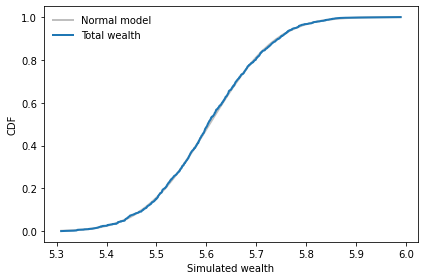

In [253]:
plot_normal_cdf(log_sim_wealth, label='Total wealth')

decorate(xlabel='Simulated wealth',
         ylabel='CDF')

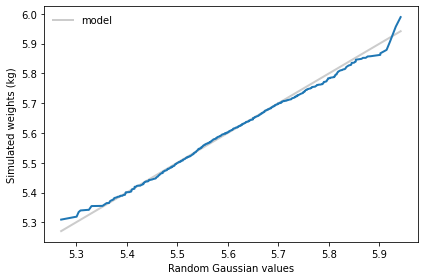

In [254]:
normal_probability_plot(log_sim_wealth)

decorate(xlabel='Random Gaussian values',
         ylabel='Simulated weights (kg)')

Although this example generates a lognormal distribution, the mechanism here -- variation in return on investment -- is not the only source of variation in wealth. And it's probably not the biggest. We'll come back to this topic in Chapter 9.

## Mandelbrot's Hypothesis

From Chapter 8 of [Think Complexity](https://greenteapress.com/complexity2/html/thinkcomplexity2009.html#sec83):

> In *The Fractal Geometry of Nature*, Benoit Mandelbrot proposes what he calls a "heretical" explanation for the prevalence of heavy-tailed distributions in natural systems. It may not be, as Bak suggests, that many systems can generate this behavior in isolation. Instead there may be only a few, but interactions between systems might cause the behavior to propagate.
>
> To support this argument, Mandelbrot points out:
>
> *    The distribution of observed data is often "the joint effect of a fixed underlying true distribution and a highly variable filter".
> *    Heavy-tailed distributions are robust to filtering; that is, "a wide variety of filters leave their asymptotic behavior unchanged".

This argument is pretty abstract, since it does not specify what "joint effect" or "variable filter" are meant to correspond to in the world.

But one kind of filter he might have had in mind is convolution, which is the operation that computes the distribution of a sum.
Continuing the wealth example, suppose wealth is the sum of several factors and only one of them is heavy tailed.

What does it look like if we add a Pareto distribution and a Gaussian distribution with the same mean and standard deviation?

In [291]:
size = 1000
sample1 = np.random.pareto(0.5, size=size)
mean, std = sample1.mean(), sample1.std()
mean, std

(2265.8159231522914, 44889.928265885916)

In [292]:
sample2 = np.random.normal(mean, std, size=size)
sample2.mean(), sample2.std()

(2616.0165803687096, 44091.389841931275)

In [293]:
total = sample1 + sample2

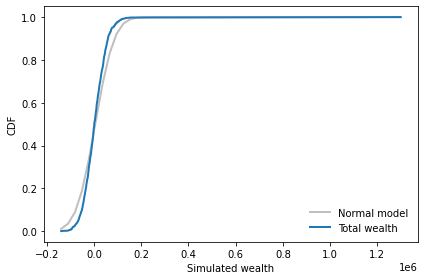

In [294]:
plot_normal_cdf(total, label='Total wealth')

decorate(xlabel='Simulated wealth',
         ylabel='CDF')

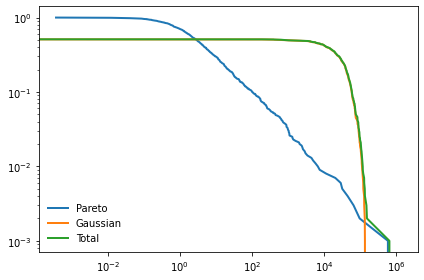

In [295]:
cdf1 = Cdf.from_seq(sample1)
(1-cdf1).plot(label='Pareto')

cdf2 = Cdf.from_seq(sample2)
(1-cdf2).plot(label='Gaussian')

cdf_total = Cdf.from_seq(total)
(1-cdf_total).plot(label='Total')
decorate(xscale='log', yscale='log')

One of the challenges of working with the Pareto distribution is that the results are highly variable, even with large sample sizes. So you might want to run this example a few times, maybe with some larger values of `size`.

What can we say about the tail behavior of `total`?

And what does this imply about Mandelbrot's explanation?